I dette programmet skal vi regne ut innstrålt effekt på taket til Amalie Skram. Til dette bruker vi et bibliotek kalt suncalc som kan gi oss vinklene for solposisjon. Vi må lese inn et datasett fra UiB som inneholder den totale innstrålingen i et punkt. Det er noen problemer med å bruke dette biblioteket som vi møte underveis. 

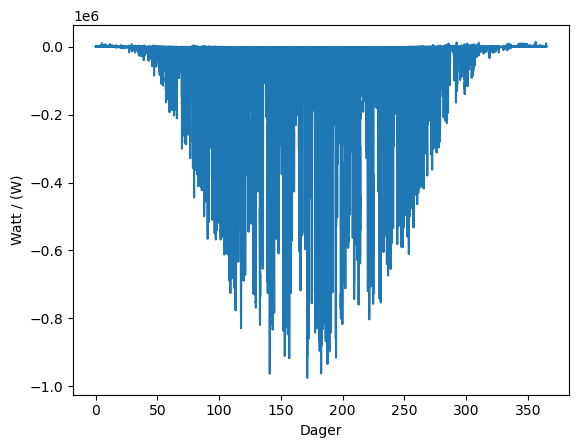

In [1]:
from suncalc import get_position, get_times
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import numpy as np
import os

# definerer arealvektoren til taket
A = np.array([308.0,1148.9,-7248.3])

# koordinater til skolen
lon = 5.338874
lat = 60.385389

'''
leser inn datasettet, 9999.99 er målefeil.
Ved å bytte om på linjene under vil det dannes 
et plott med fire stolper opp mot 10000.
'''
#df = pd.read_csv('2022.csv')
df = pd.read_csv('2022.csv',na_values = 9999.99)


# Funksjon som regner vinkelen mellom en arealvektor til
# taket og en retningsvektor opp mot solen.

def vinkel(az,al,arealvektor):
    retningsvektor = np.array([np.cos(az),np.sin(az),np.tan(al)])
    # Formel for vinkel mellom to vektorer
    a = np.arccos(retningsvektor@arealvektor/np.linalg.norm(arealvektor)/np.linalg.norm(retningsvektor))
    return a
               
# tilpasser tidsangivning til riktig format
df['Dato'] = df['Dato'].str.ljust(11) 
df['Dato'] = df['Dato'] + df['Tid']
df = df.drop('Tid', axis=1)

# skifter tiden til UTC-tidssonen
utc = []
for i in range(len(df['Dato'])):
    local_time = df['Dato'][i]
    local_tz = pytz.timezone('Europe/Oslo')
    utc_tz = pytz.utc
    
    # Finner utc-tid utifra lokal-tid og -tidssone
    local_dt = datetime.strptime(local_time, '%Y-%m-%d %H:%M')
    local_dt = local_tz.localize(local_dt)
    utc_dt = local_dt.astimezone(utc_tz)
    utc.append(str(utc_dt)[:16])
          
# lager en kopi for å jobbe med
df1 = df.copy()
df1['Dato'] = utc

# lager et dictionary med vinkler
Lon = np.ones(len(df1['Dato']))*lon
Lat = np.ones(len(df1['Dato']))*lat
dict = get_position(df1['Dato'], Lon, lat) 

# omdanner dict til en DataFrame og legger sammen med df1
dict_df = pd.DataFrame(dict)
df1 = pd.concat([df1, dict_df], axis=1)


# Fjerner alle rader der Globalstråling er mindre enn 0
df1.drop(df1[df1['Globalstraling'] < 0.1].index, inplace=True)

# Endrer vinkelverdiene siden de er oppgitt på en merkelig måte
df1['azimuth'] = df1['azimuth']* -1 + np.pi/2


# Regner energi for hver periode
indeks_liste = list(df1.index.values)
energi = []

for i in indeks_liste:
    # Finner vinkler
    az = df1['azimuth'][i]
    al = df1['altitude'][i]
    # Finner vinkel mellom taket og solen
    vinkel_sol = vinkel(az,al,A)
    
    # legger data inn i en liste
    energi.append(np.cos(vinkel_sol) * df1['Globalstraling'][i] * np.linalg.norm(A))

    
# Regner med paneleffektivitet 
energi = np.array(energi)
energi = energi*0.21

# Sjekker for NaN-verdier
energi = energi[np.isfinite(energi)]

# Plotter resultatene
tid = np.linspace(0,365,len(energi))
plt.plot(tid,energi)
plt.xlabel('Dager')
plt.ylabel('Watt / (W)');

Datasettet blir negativt fordi vi regner skalaproduktet av to motstående vektorer. 

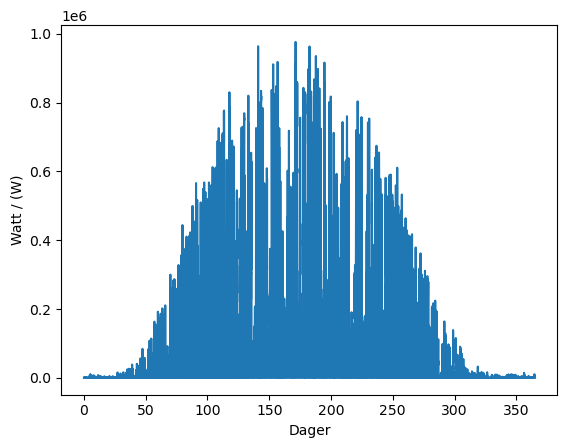

In [2]:
# Plotter resultatene bedre
tid = np.linspace(0,365,len(energi))
plt.plot(tid,abs(energi))
plt.xlabel('Dager')
plt.ylabel('Watt / (W)');

In [3]:
# Summerer energien og gjør om til Wh
total = sum(abs(energi))
total = total/(6*1000)
print(f'Totalen blir {round(total,2)} kWh')

Totalen blir 507252.95 kWh


Ifølge forbrukerguiden (https://forbrukerguiden.no/normalt-stromforbruk/#:~:text=Normalt%20str%C3%B8mforbruk%20varierer%20med%20st%C3%B8rrelsen%2C%20men%20de%20fleste,vil%20ha%20et%20normalt%20str%C3%B8mforbruk%20p%C3%A5%20500%20kWh.) vil et vanlig strømforbruk for en leilighet på 100 m^2 være på rundt 500 kWh i måneden.

In [4]:
# Deler på vanlig forbruk for et år
round(total/(500*12),2)

84.54

Dette er hvor mange leiligheter som vil kunne fungere bare på energi fra solcellepanelene, totalt sett. I realiteten vil panelene supplere mye mer effekt til leilighetene om sommeren enn om vinteren. Da må det suppleres med andre kilder om vinteren og spres til flere leiligheter om sommeren. Et vannkraftverk er et alternativ til en strømkilde som kunne fungert bra sammen med panelene.